In [1]:
import sys

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")

physical_device = tf.config.experimental.list_physical_devices('GPU')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.1
GPU is available


In [21]:
from matplotlib import pyplot as plt
import pathlib

## create train and validation datasets
DB_PATH = "./fashiondb//images"
BUFFER_SIZE = 10000
BATCH_SIZE = 32
IMG_WIDTH = 128
IMG_HEIGHT = 128

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 255)
    return input_image

@tf.function()
def random_jitter(input_image):
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        
    return input_image

def load_image_train(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

def load_image_test(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image


data_dir = pathlib.Path(DB_PATH)
image_count = len(list(data_dir.glob('*.jpg')))
dataset = tf.data.Dataset.list_files(DB_PATH+'\\*.jpg')


val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_image_test)
val_ds = val_ds.batch(BATCH_SIZE)

35553
8888


In [22]:
val_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

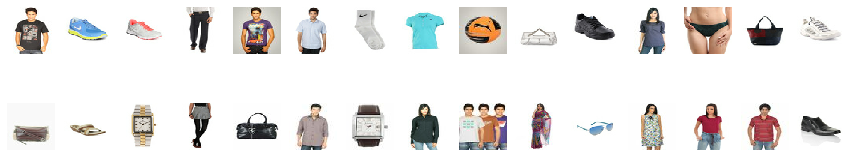

In [23]:
#image_batch = next(iter(train_ds))

plt.figure(figsize=(15, 5))
for images,targets in val_ds.take(1):
    for i in range(30):
        ax = plt.subplot(3, 15, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.axis("off")
        
plt.savefig("./Images/Visualizations.jpg")


In [24]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K

latent_dim = 256  # Number of latent dimension parameters

input_img = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img)
x = BatchNormalization()(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim, kernel_initializer='zeros',bias_initializer='zeros')(x)

(None, 16, 16, 4)


In [25]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

encoder = Model(input_img,z)

encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 32)   896         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [26]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(4096, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
x = Reshape((8,8,64))(x)

x = Conv2DTranspose(32, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(16, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(8, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(3, (3, 3),strides= 2, padding='same', activation='sigmoid')(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
pred = decoder(z)

decoder.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 intermediate_decoder (Dense  (None, 4096)             1052672   
 )                                                               
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 32)       18464     
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                           

In [27]:
from tensorflow.keras.metrics import binary_crossentropy

def vae_loss(x, pred):
    x = K.flatten(x)
    pred = K.flatten(pred)
    # Reconstruction loss
    #reconst_loss = 100 * binary_crossentropy(x, pred)
    reconst_loss = 1000*K.mean(K.square(x - pred))
    
    # KL divergence
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    
    return (reconst_loss + kl_loss)

In [28]:
# VAE model statement
vae = Model(input_img,pred)
vae.add_loss(vae_loss(input_img,pred))
optimizer = Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=None)

vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 64, 64, 32)   896         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [29]:
train_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

In [30]:
val_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>

In [31]:
from keras.callbacks import EarlyStopping
from os import path
# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

if(path.exists("./checkpoints")):
    vae.load_weights("./checkpoints/vae")
else:
    history = vae.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping],verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    vae.save_weights("./checkpoints/vae")

Epoch 1/50


AttributeError: in user code:

    C:\Users\acer\Anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\acer\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\acer\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\acer\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\engine\training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:655 apply_gradients
        grads_and_vars = self._aggregate_gradients(grads_and_vars)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:474 _aggregate_gradients
        return self.gradient_aggregator(grads_and_vars)
    C:\Users\acer\Anaconda3\lib\site-packages\keras\optimizer_v2\utils.py:33 all_reduce_sum_gradients
        if strategy_supports_no_merge_call():

    AttributeError: module 'tensorflow.compat.v2.__internal__.distribute' has no attribute 'strategy_supports_no_merge_call'
